<a href="https://colab.research.google.com/github/bhargav1237874/grandhe_INFO5731_spring2021/blob/main/In_class_exercise_07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The seventh in-class-exercise (20 points in total, 3/16/2021)**

Question description: In the last in-class-exercise (exercise-06), you collected the titles of 100 articles about data science, natural language processing, and machine learning. The 100 article titles will be used as the text corpus of this exercise. Perform the following tasks:

## (1) (8 points) Generate K topics by using LDA, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here: 

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [3]:
# Installing nltk and stopwords

import nltk
nltk.download('stopwords')

# Installing java

import os
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
  !java -version
install_java()

# Upgrading Gensim

!pip install --upgrade gensim

# Downloading en module in spacy

import spacy.cli
spacy.cli.download("en")





[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
openjdk version "11.0.10" 2021-01-19
OpenJDK Runtime Environment (build 11.0.10+9-Ubuntu-0ubuntu1.18.04)
OpenJDK 64-Bit Server VM (build 11.0.10+9-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)
     |████████████████████████████████| 24.2MB 1.6MB/s 
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [4]:
# Importing Required Modules

import re
import numpy as np
import pandas as pd
from pprint import pprint
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy

!pip install pyLDAvis

import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# Importing Stopwords module from nltk

from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])




     |████████████████████████████████| 1.7MB 4.3MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-3.2.2-py2.py3-none-any.whl size=135593 sha256=fbb8e54b3f78425ed84c5dd6064c2ad41e50a5c73ae05e7c93cdbe42de99f098
  Stored in directory: /root/.cache/pip/wheels/74/df/b6/97234c8446a43be05c9a8687ee0db1f1b5ade5f27729187eae
Successfully built pyLDAvis


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


In [6]:
# Reading Google Articles from csv to df

google_articles_titles = pd.read_csv('/content/output.csv', encoding = "ISO-8859-1")
google_articles_titles.head(10)

,title
0,Natural Language Processing in Information Ret...
1,Recent Trends in Deep Learning Based Natural L...
2,Automated Encoding of Clinical Documents Based...
3,Voice controlled home automation system using ...
4,Detection of Duplicate Defect Reports Using Na...
5,extracting sentiments about a given topic usin...
6,Clinical Natural Language Processing in langua...
7,Extracting information on pneumonia in infants...
8,Policy enforcement using natural language proc...
9,Natural Language Processing in Biomedicine: A ...


In [7]:
# Dataframe to list

data = google_articles_titles['title'].tolist()

# Tokenization and punctuation

data_words = []
for line in data:
  data_words.append(gensim.utils.simple_preprocess(str(line), deacc=True))

# Building Bigrams and Trigrams models

bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)


# Removing Stopwords and getting Bigrams
after_stopword_removal = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in data_words]
bigrams = [bigram_mod[doc] for doc in after_stopword_removal]

# Lemmatization

nlp = spacy.load('en', disable=['parser', 'ner'])
allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']
after_lemmatization = []
for sent in bigrams:
  doc = nlp(" ".join(sent)) 
  after_lemmatization.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])


# Building Dictionary, Corpus and Term Document Frequency

id2word = corpora.Dictionary(after_lemmatization)
texts = after_lemmatization
corpus = [id2word.doc2bow(text) for text in after_lemmatization]
print(corpus[:1])

[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[(0, 1), (1, 1), (2, 1), (3, 1)]]


[[('language', 1), ('natural', 1), ('processing', 1), ('retrieval', 1)]]

In [8]:
# Building LDA Model with 20 topics

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

# Compute Model Perplexity and Coherence Score

print('\nPerplexity: ', lda_model.log_perplexity(corpus)) 
coherence_model_lda = CoherenceModel(model=lda_model, texts=after_lemmatization, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -3.271208257120561

Coherence Score:  0.5151241829928082


In [ ]:
AA


--2021-03-20 04:53:54--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip.2’

mallet-2.0.8.zip.2  100%[===================>]  15.43M  13.5MB/s    in 1.1s    

2021-03-20 04:53:55 (13.5 MB/s) - ‘mallet-2.0.8.zip.2’ saved [16184794/16184794]

Archive:  mallet-2.0.8.zip
replace mallet-2.0.8/bin/classifier2info? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: mallet-2.0.8/bin/classifier2info  
  inflating: mallet-2.0.8/bin/csv2classify  
  inflating: mallet-2.0.8/bin/csv2vectors  
  inflating: mallet-2.0.8/bin/mallet  
  inflating: mallet-2.0.8/bin/mallet.bat  
  inflating: mallet-2.0.8/bin/mallethon  
  inflating: mallet-2.0.8/bin/prepend-license.sh  
  inflating: mallet-2.0.8/bin/svmlight2vectors  
  inflating: 

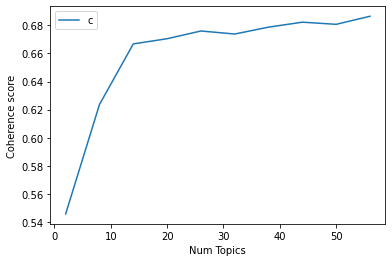

In [9]:
# Setting environment Path and giving Mallet Path


!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
mallet_path = '/content/mallet-2.0.8/bin/mallet'

# Building LDA Mallet Model

ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

# Compute Coherence Value for LDA

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=after_lemmatization, start=2, limit=60, step=6)

limit=60; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()


In [10]:
for no_of_topics, cv in zip(range(2, 60, 6), coherence_values):
  print("Num Topics:", no_of_topics, " - Coherence Value:", round(cv, 4))

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=14, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)


# PRINTING TOPICS

pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

# TOPIC VISUALIZATION

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis



Num Topics: 2  - Coherence Value: 0.5457
Num Topics: 8  - Coherence Value: 0.6237
Num Topics: 14  - Coherence Value: 0.6668
Num Topics: 20  - Coherence Value: 0.6705
Num Topics: 26  - Coherence Value: 0.676
Num Topics: 32  - Coherence Value: 0.6738
Num Topics: 38  - Coherence Value: 0.6788
Num Topics: 44  - Coherence Value: 0.6823
Num Topics: 50  - Coherence Value: 0.6808
Num Topics: 56  - Coherence Value: 0.6865
[(0,
  '0.152*"processing" + 0.152*"use" + 0.152*"natural" + 0.152*"language" + '
  '0.152*"policy" + 0.152*"enforcement" + 0.002*"automation" + 0.002*"home" + '
  '0.002*"textual" + 0.002*"thing"'),
 (1,
  '0.019*"language" + 0.019*"natural" + 0.019*"processing" + 0.019*"use" + '
  '0.019*"report" + 0.019*"research" + 0.019*"english" + 0.019*"radiology" + '
  '0.019*"technique" + 0.019*"topic"'),
 (2,
  '0.136*"language" + 0.136*"processing" + 0.136*"natural" + 0.135*"radiology" '
  '+ 0.069*"use" + 0.069*"report" + 0.068*"review" + 0.068*"systematic" + '
  '0.068*"infant" + 

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
13     0.018996 -0.122300       1        1  15.560772
12     0.115524 -0.071038       2        1  13.938558
9      0.112629 -0.014877       3        1  12.108853
6      0.107819 -0.052904       4        1  11.188720
5     -0.029198  0.219507       5        1  10.477513
2      0.104228 -0.034821       6        1   9.194166
8      0.175830 -0.034298       7        1   9.115631
3      0.059563  0.172788       8        1   6.495795
11     0.002076  0.057848       9        1   5.442074
0      0.135338 -0.001449      10        1   4.854835
4     -0.195271 -0.032064      11        1   0.407453
7     -0.198298 -0.027793      12        1   0.407392
1     -0.204618 -0.029300      13        1   0.404118
10    -0.204618 -0.029300      14        1   0.404118, topic_info=         Term       Freq      Total Category  logprob  loglift
23     report  26.000000  26.000000  Default  30.0000  30.0000
42   research  15.000000  15.000000  Default  29.0000  29.0000
18     system  20.000000  20.000000  Default  28.0000  28.0000
20        use  60.000000  60.000000  Default  27.0000  27.0000
21     defect  11.000000  11.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
25       give   0.057034  10.307583  Topic14  -3.9703   0.3142
26  sentiment   0.057034  10.307583  Topic14  -3.9703   0.3142
27  technique   0.057034  10.307583  Topic14  -3.9703   0.3142
28      topic   0.057034  10.307583  Topic14  -3.9703   0.3142
46     cancer   0.057034  11.204115  Topic14  -3.9703   0.2308

[659 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
36        9  0.899421  architecture
9         5  0.892403      automate
13        1  0.869890    automation
4         5  0.872822          base
37        9  0.899421   biomedicine
...     ...       ...           ...
20        3  0.164255           use
20        4  0.147829           use
20        6  0.082127           use
20        7  0.164255           use
20       10  0.098553           use

[92 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[14, 13, 10, 7, 6, 3, 9, 4, 12, 1, 5, 8, 2, 11])

## (2) (8 points) Generate K topics by using LSA, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here:

https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python

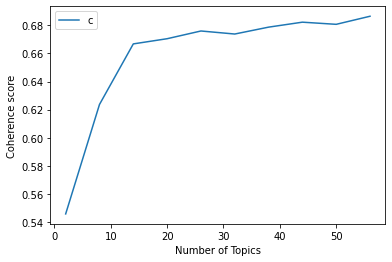

In [11]:
# 

from gensim.models import LsiModel

lsamodel = LsiModel(corpus, 20, id2word)

def compute_coherence_values_lsi(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=20, id2word = dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values


start,stop,step=2,60,6
model_list_lsa, coherence_values_lsa = compute_coherence_values_lsi(id2word, corpus,after_lemmatization,stop, start, step)
x = range(start, stop, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()    


In [12]:
for no_of_topics, cv in zip(range(2, 60, 6), coherence_values_lsa):
  print("Num Topics:", no_of_topics, " - Coherence Value:", round(cv, 4))

pprint(lsamodel.print_topics())




Num Topics: 2  - Coherence Value: 0.5175
Num Topics: 8  - Coherence Value: 0.5131
Num Topics: 14  - Coherence Value: 0.5248
Num Topics: 20  - Coherence Value: 0.5206
Num Topics: 26  - Coherence Value: 0.5317
Num Topics: 32  - Coherence Value: 0.5202
Num Topics: 38  - Coherence Value: 0.527
Num Topics: 44  - Coherence Value: 0.5305
Num Topics: 50  - Coherence Value: 0.5279
Num Topics: 56  - Coherence Value: 0.519
[(0,
  '0.531*"language" + 0.489*"processing" + 0.489*"natural" + 0.353*"use" + '
  '0.151*"report" + 0.115*"system" + 0.071*"research" + 0.063*"pathology" + '
  '0.063*"cancer" + 0.061*"control"'),
 (1,
  '0.390*"system" + 0.337*"automation" + 0.337*"nlp" + 0.337*"home" + '
  '0.337*"internet" + 0.337*"control" + 0.337*"thing" + -0.223*"report" + '
  '-0.134*"research" + -0.113*"pathology"'),
 (2,
  '-0.472*"use" + -0.392*"report" + 0.299*"clinical" + 0.269*"language" + '
  '0.228*"base" + -0.218*"pathology" + -0.218*"cancer" + -0.212*"research" + '
  '0.172*"challenge" + 0.17

## (3) (4 points) Compare the results generated by the two topic modeling algorithms, which one is better? You should explain the reasons in details.

In [ ]:
'''
Latent Semantic Analysis has lower accuracy than Latent Dirichlet allocation has better accuracy. Here, The Coherence value for optimal number of topics for LSA is 46 where as for LDA is 72. From this we will get to know that Accuracy for LDA is better. LDA has better accuracy that means we can easily generalize LDA model to other new documents. LSA has less interpretability among the topics beacuse of dimensionality reduction where as we interpret topic very easily in LDA. I got 14 topics for LDA which are highly interpretable than 20 topics of LSA. LSA has less efficient representation.

'''